# Pasos a seguir:
    [-] Descargar geometrias de radios censales (completado en notebook 01)

    [-] Disolver a nivel de fracciones censales y departamentos

    [-] Guardar las geometrias que obtuvimos.

## Disolver

In [2]:
# import pandas as pd
import geopandas as gpd

In [40]:
year = '1991' # Solo 2010 porque los anteriores tienen temitas con radios que faltan identificar. 
# En esos casos un dissolve va a quedar con algunos 'huecos'.


In [41]:
CONICET_radios = gpd.read_file('./censos_shp_CONICET/'+year+'_RADIOS ARGENTINA/')
CONICET_radios['geometry'] = CONICET_radios['geometry'].buffer(1) # Un metro de buffer para garantizar que no queden marcas entre radios
# CONICET_radios = CONICET_radios.to_crs({'init': "EPSG:4326"})

## El archivo de rodriguez de 2010 tiene un problemita por el cual los codigos de deptos de la provincia de Formosa fueron sobreescritos con los codigos de fracciones. 
# Para constatar que afecta solamente a todas las entradas de formosa (PROV 34)
# (CONICET_radios['COD_2010'].str[2:5] == CONICET_radios.DEPTO_).groupby(CONICET_radios.PROV_).sum()/CONICET_radios.groupby(CONICET_radios.PROV_).size()
if year == '2010':    # Lo corregimos
    CONICET_radios['DEPTO_'] = CONICET_radios['COD_2010'].str[2:5]
    

### Fracciones censales

In [42]:
#  disuelto a nivel Fracciones
CONICET_fracs = CONICET_radios.dissolve(['PROV_', 'DEPTO_', 'FRACC_']).reset_index()

columnas_radios = ['COD_'+year,'RADIO_','OBS_','CODAGLO_1','CODAGLO_2','CODAGLO_3','CODAGLO_4','CODAGLO_5']
## Quitamos las columnas de nivel radio, que deberian desaparecer al disolver:

CONICET_fracs = CONICET_fracs.drop(columnas_radios, 1)

CONICET_fracs.tail()

,PROV_,DEPTO_,FRACC_,geometry
4547,94,014,01,"MULTIPOLYGON (((3360785.570 3918244.678, 33607..."
4548,94,014,02,"MULTIPOLYGON (((3413710.676 3917902.237, 34137..."
4549,94,014,03,"MULTIPOLYGON (((3553808.766 3940015.144, 35538..."
4550,94,014,04,"POLYGON ((3350706.494 3922377.483, 3350700.368..."
4551,94,014,05,"POLYGON ((3351677.457 3921863.926, 3351981.011..."


### Departamentos

In [43]:
CONICET_dptos = CONICET_fracs.dropna(subset = ['geometry']).dissolve(['PROV_', 'DEPTO_']).reset_index()
CONICET_dptos = CONICET_dptos.drop(['FRACC_'], 1)
## Quitamos la columna de nivel fraccion, que deberia desaparecer al disolver:

CONICET_dptos.tail()

,PROV_,DEPTO_,geometry
517,90,105,"POLYGON ((3578949.470 7037156.000, 3578901.479..."
518,90,112,"POLYGON ((3577121.250 7062005.444, 3577121.250..."
519,90,119,"POLYGON ((3572926.961 7033680.224, 3572926.961..."
520,94,007,"POLYGON ((3428914.672 4000999.835, 3428967.329..."
521,94,014,"MULTIPOLYGON (((3607155.497 3937078.428, 36071..."


## Guardar shp de los poligonos disueltos

In [44]:
import os
dissolved_dir = './censos_shp_CONICET_dissolved'
if not os.path.exists(dissolved_dir):
    os.makedirs(dissolved_dir)
    
CONICET_dptos.to_file(dissolved_dir+'/dptos_'+year+'.shp')
CONICET_fracs.to_file(dissolved_dir+'/fracs_'+year+'.shp')

## Demo

In [45]:
from shapely.geometry import box
import matplotlib.pyplot as plt
%matplotlib inline

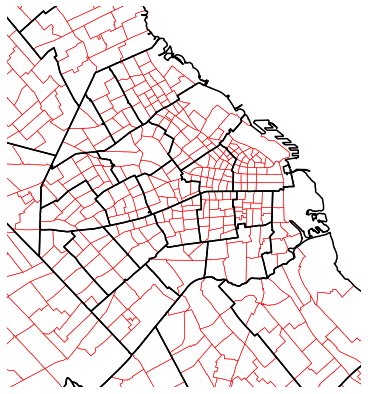

In [46]:
fig, ax = plt.subplots(1, figsize = (7, 7))

CONICET_fracs.plot(color = 'None', edgecolor = 'r', ax = ax, lw = .5)
CONICET_dptos.plot(color = 'None', edgecolor = 'k', ax = ax, lw = 1.5)

# plot bounds
custom_bounds = CONICET_dptos.loc[CONICET_dptos.PROV_ == '02'].total_bounds # CABA
x0, y0, x1, y1 = box(*custom_bounds).buffer(2000).bounds  ## 2km alrededor de CABA
# minx, miny, maxx, maxy

ax.set_xlim(x0, x1); ax.set_ylim(y0, y1)
ax.axis('off')

plt.show()

# Ejemplo, Deptos y Fracciones en zona CABA